In [21]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

In [29]:
# Download training data from open datasets.
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

In [31]:
train_data.data.shape

torch.Size([60000, 28, 28])

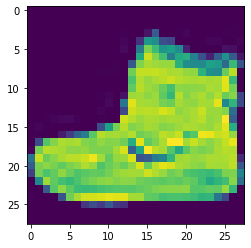

In [32]:
plt.imshow(train_data.data[0])

In [33]:
test_data.data[0].shape

torch.Size([28, 28])

In [34]:
train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=64)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=64)

In [38]:
train_dataloader.__iter__().next()[0].shape

torch.Size([64, 1, 28, 28])

In [42]:
for x, y in train_dataloader:
    print("x [n, c, h, w]: ", x.shape)
    print("y             : ", y.shape)
    break

x [n, c, h, w]:  torch.Size([64, 1, 28, 28])
y             :  torch.Size([64])


In [43]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using {} device".format(device))

Using cpu device


In [44]:
class HoNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
            nn.ReLU(),
        )
    
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
    
model = HoNet().to(device)
print(model)

HoNet(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
    (5): ReLU()
  )
)


In [73]:
model.parameters().__next__()

Parameter containing:
tensor([[ 0.0283, -0.0196, -0.0332,  ...,  0.0260, -0.0116,  0.0297],
        [ 0.0314,  0.0234,  0.0128,  ...,  0.0206, -0.0316,  0.0309],
        [-0.0308,  0.0112, -0.0189,  ..., -0.0005, -0.0244,  0.0025],
        ...,
        [-0.0193,  0.0138,  0.0274,  ...,  0.0143, -0.0053, -0.0139],
        [-0.0170,  0.0050,  0.0244,  ..., -0.0083,  0.0042,  0.0339],
        [ 0.0073, -0.0029,  0.0062,  ..., -0.0210,  0.0009, -0.0031]],
       requires_grad=True)

In [74]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)  # why need the params?

In [75]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # loss
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # backprop
        optimizer.zero_grad()
        loss.backward()  # backprop?
        optimizer.step()
        
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print("Loss: {:>7.4f}   [{:>5d}/{:>5d}]".format(loss, current, size))

### Notes
- `optimizer.zero_grad()` is needed to reset the accumulated gradients on the optimizer. This would allow easy stacking(?) of gradients.
- Q. How does optimizer recieve backprops?

In [84]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).float().sum().item()
    test_loss /= size
    accuracy = correct / size
    print("Test Error: Acc={:.2f}% Loss={:.4f}".format(accuracy * 100, test_loss))

In [86]:
epochs = 10
for i in range(epochs):
    print(" Epoch {:d} ".format(i + 1).center(80, "#"))
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model)
print("Done")

################################### Epoch 1 ####################################
Loss:  1.6226   [    0/60000]
Loss:  1.5371   [ 6400/60000]
Loss:  1.4517   [12800/60000]
Loss:  1.4688   [19200/60000]
Loss:  1.3084   [25600/60000]
Loss:  1.5072   [32000/60000]
Loss:  1.4864   [38400/60000]
Loss:  1.6641   [44800/60000]
Loss:  1.5922   [51200/60000]
Loss:  1.3298   [57600/60000]
Test Error: Acc=47.0% Loss=0.0232
################################### Epoch 2 ####################################
Loss:  1.5916   [    0/60000]
Loss:  1.5161   [ 6400/60000]
Loss:  1.4216   [12800/60000]
Loss:  1.4530   [19200/60000]
Loss:  1.2895   [25600/60000]
Loss:  1.4903   [32000/60000]
Loss:  1.4695   [38400/60000]
Loss:  1.6523   [44800/60000]
Loss:  1.5670   [51200/60000]
Loss:  1.3156   [57600/60000]
Test Error: Acc=47.6% Loss=0.0229
################################### Epoch 3 ####################################
Loss:  1.5665   [    0/60000]
Loss:  1.4985   [ 6400/60000]
Loss:  1.3956   [12800/60000]

In [87]:
torch.save(model.state_dict(), "model.pth")
print("Save PyTorch model state to model.pth")

Save PyTorch model state to model.pth


In [88]:
model = HoNet()
model.load_state_dict(torch.load("model.pth"))  # wow!

<All keys matched successfully>

In [90]:
d = torch.load("model.pth")

In [89]:
test(test_dataloader, model)

Test Error: Acc=51.7% Loss=0.0216


Predicted: "Shirt", Actual: "Shirt"


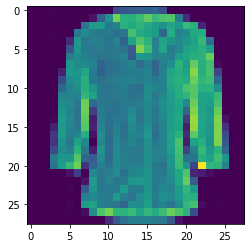

In [103]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
index = 4
x, y = test_data[index][0], test_data[index][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
    plt.imshow(x[0])